In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
import json
import ast
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_recall_fscore_support
import geopandas as gpd
import optuna

In [85]:
df = pd.read_csv('dataset.csv')

In [86]:
df

,Unnamed: 0,name,url,city,cuisine,avgRating,numReviews,priceRange,latitude,longitude,telephone,postalCode,streetAddress,addressLocality,addressRegion,openingHoursSpecification,addressString,geoString,ratingString
0,0,Market Cafe,https://www.ubereats.com/new-york/food-deliver...,new-york,"['Pizza', 'American', 'Italian']",NaN,NaN,$,40.752349,-73.975021,1.212682e+10,10017,425 Lexington Ave,New York,NY,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.752...",{}
1,1,Dunkin' (850 8th Ave),https://www.ubereats.com/new-york/food-deliver...,new-york,"['Breakfast and Brunch', 'Donuts']",4.1,39.0,$,40.762923,-73.985342,1.212246e+10,10019,850 8th Ave,New York,NY,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.762...","{'@type': 'AggregateRating', 'ratingValue': 4...."
2,2,The Drop,https://www.ubereats.com/new-york/food-deliver...,new-york,"['Coffee and Tea', 'American', 'Breakfast and ...",NaN,NaN,$,40.707828,-74.005660,NaN,10038,111 John Street,New York,NY,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.707...",{}
3,3,Poke Bowl (386 Canal St),https://www.ubereats.com/new-york/food-deliver...,new-york,"['Sushi', 'Asian', 'Japanese']",NaN,NaN,$,40.721287,-74.004971,1.347583e+10,10013,386 Canal St,New York,NY,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.721...",{}
4,4,NOODLE CULTURE,https://www.ubereats.com/new-york/food-deliver...,new-york,"['Chinese', 'Asian', 'Noodles']",NaN,NaN,$,40.740975,-74.004635,1.347990e+10,10014,353 W 14th St,New York,New York,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.740...",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,5204,Earle Cafe,https://www.ubereats.com/new-jersey/food-deliv...,newark-new-jersey,"['Middle Eastern', 'Burgers', 'Sandwich', 'Deli']",4.2,88.0,$,40.730331,-74.061955,1.201653e+10,07306,57 Sip Ave,Jersey City,NJ,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.730...","{'@type': 'AggregateRating', 'ratingValue': 4...."
5205,5205,asia garden,https://www.ubereats.com/new-jersey/food-deliv...,newark-new-jersey,"['Chinese', 'Asian', 'Noodles']",NaN,NaN,NaN,40.683170,-74.269190,1.908852e+10,07083,480 Chestnut Street,Union,NJ,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.683...",{}
5206,5206,One Stop Island Grill,https://www.ubereats.com/new-jersey/food-deliv...,newark-new-jersey,"['Caribbean', 'Chicken', 'Seafood']",NaN,NaN,NaN,40.761850,-74.203000,1.862520e+10,07017,188 William Street Floor 1,East Orange,NJ,"[{'@type': 'OpeningHoursSpecification', 'dayOf...","{'@type': 'PostalAddress', 'addressLocality': ...","{'@type': 'GeoCoordinates', 'latitude': 40.761...",{}
5207,5207,"Rumba Cubana - Clifton, NJ",https://www.ubereats.com/new-jersey/food-deliv...,newark-new-jersey,"['Cuban', 'Caribbean', 'Spanish', 'Latin Ameri...",4.6,500.0,$,40.835567,-74.125035,1.973777e+10,NaN,NaN,NaN,NaN,"[{'@type': 'OpeningHoursSpecification', 'dayOf...",NaN,"{'@type': 'GeoCoordinates', 'latitude': 40.835...","{'@type': 'AggregateRating', 'ratingValue': 4...."


In [87]:
# fix json string quotes 
def fix_json(json_string):
    if type(json_string) == type(""):
        return json_string.replace("'", '"')
    else:
        return json.dumps({'rating': ''})

# fix double quotes for ratingString column
df['ratingString'] = df['ratingString'].apply(lambda x: fix_json(x))

In [88]:
# normalise rating string
df_json = pd.json_normalize(df['ratingString'].apply(json.loads))
df = pd.concat([df, df_json], axis=1)

In [89]:
# convert price range categorical to numerical
def price_range(x):
    if type(x) == type(1.1):
        return 0
    return len(x)
df['priceRange'] = df['priceRange'].apply(price_range)

In [90]:
# standardize addressRegion to one format ex: New York -> NY
def normalise_address_region(x):
    if type(x) == type(''):
        y = x.split(' ')
        if len(y) > 1:
            return ''.join([i[0] for i in y])
        return x
    return x
df['addressRegion'] = df['addressRegion'].apply(normalise_address_region)

In [91]:
# drop unused column
df = df.drop(columns=['Unnamed: 0', 'telephone', 'avgRating', 'numReviews', '@type', 'rating', 'ratingString'])
df.describe()

,priceRange,latitude,longitude,ratingValue
count,5209.000000,5180.000000,5180.000000,2406.000000
mean,1.223075,40.723422,-74.064581,4.513425
std,0.543921,0.102146,0.150811,0.302956
min,0.000000,40.070888,-74.855080,2.700000
25%,1.000000,40.721287,-74.077014,4.400000
50%,1.000000,40.735804,-74.000782,4.600000
75%,1.000000,40.755890,-73.987772,4.700000
max,4.000000,40.926052,-73.908490,5.000000


In [92]:
# check number of rows with na
df.isna().sum()

name                           29
url                             0
city                            0
cuisine                        29
priceRange                      0
latitude                       29
longitude                      29
postalCode                    557
streetAddress                 521
addressLocality               521
addressRegion                 521
openingHoursSpecification      29
addressString                 521
geoString                      29
ratingValue                  2803
reviewCount                  2803
dtype: int64

In [93]:

imputer = KNNImputer(n_neighbors=2)


columns_to_impute = ['ratingValue', 'reviewCount']

# Extract the columns to impute
df_to_impute = df[columns_to_impute]

# use knn to fill Nan values
df_imputed_part = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=columns_to_impute)

In [94]:
df_combined = pd.concat([df_imputed_part, df.drop(columns=columns_to_impute)], axis=1)

In [95]:
# check again for na row count if knn imputed correctly
df_combined.isna().sum()

ratingValue                    0
reviewCount                    0
name                          29
url                            0
city                           0
cuisine                       29
priceRange                     0
latitude                      29
longitude                     29
postalCode                   557
streetAddress                521
addressLocality              521
addressRegion                521
openingHoursSpecification     29
addressString                521
geoString                     29
dtype: int64

In [96]:
df_combined.shape
df = df_combined

In [97]:
df.describe()

,ratingValue,reviewCount,priceRange,latitude,longitude
count,5209.000000,5209.000000,5209.000000,5180.000000,5180.000000
mean,4.513425,132.510391,1.223075,40.723422,-74.064581
std,0.205874,99.040358,0.543921,0.102146,0.150811
min,2.700000,10.000000,0.000000,40.070888,-74.855080
25%,4.513425,81.000000,1.000000,40.721287,-74.077014
50%,4.513425,132.510391,1.000000,40.735804,-74.000782
75%,4.513425,132.510391,1.000000,40.755890,-73.987772
max,5.000000,500.000000,4.000000,40.926052,-73.908490


In [98]:
df.drop_duplicates()
df.shape

(5209, 16)

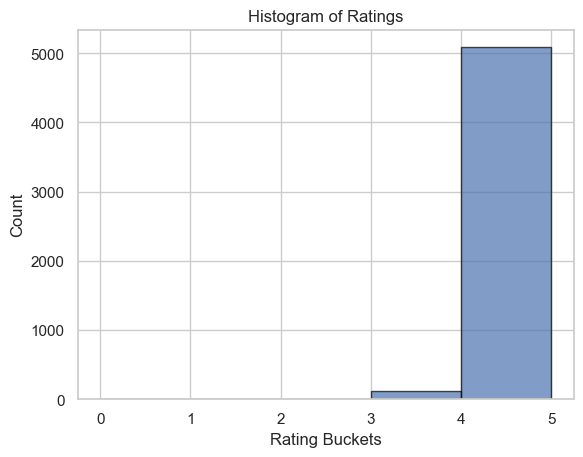

In [99]:
## Plot histogram for ratings
plt.hist(df.ratingValue, bins=[0, 1, 2, 3, 4, 5], edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Rating Buckets')
plt.ylabel('Count')
plt.title('Histogram of Ratings')
plt.show()

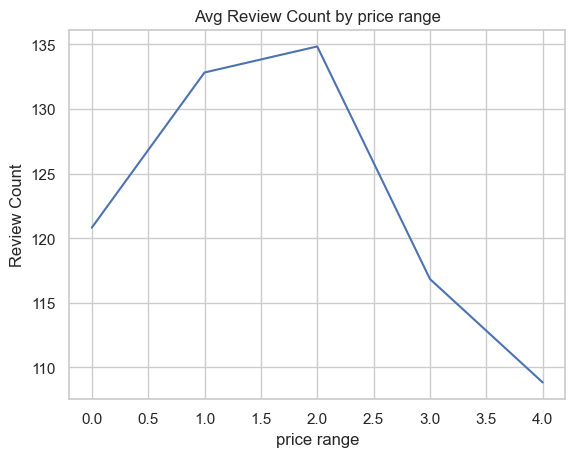

In [100]:
## plot graph for avg review count by price range
grouped_df = df.groupby('priceRange')['reviewCount'].mean().reset_index()
plt.plot(grouped_df['priceRange'], grouped_df['reviewCount'])

# Add title and labels
plt.title('Avg Review Count by price range')
plt.xlabel('price range')
plt.ylabel('Review Count')
plt.savefig('plots/avg_review_count_by_price_range.png')
plt.show()

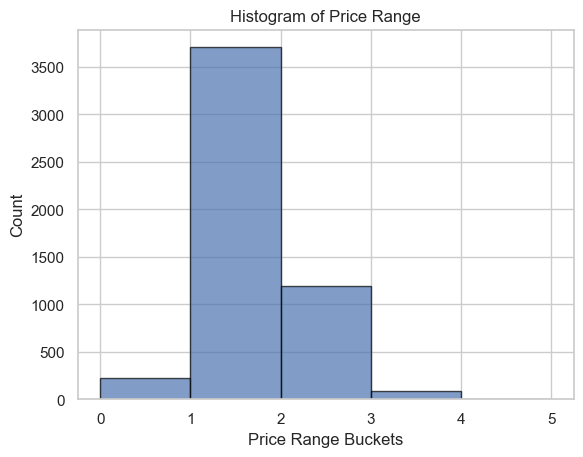

In [101]:
# plot histogram for price range buckets
plt.hist(df.priceRange, bins=[0, 1, 2, 3, 4, 5], edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Price Range Buckets')
plt.ylabel('Count')
plt.title('Histogram of Price Range')
plt.show()

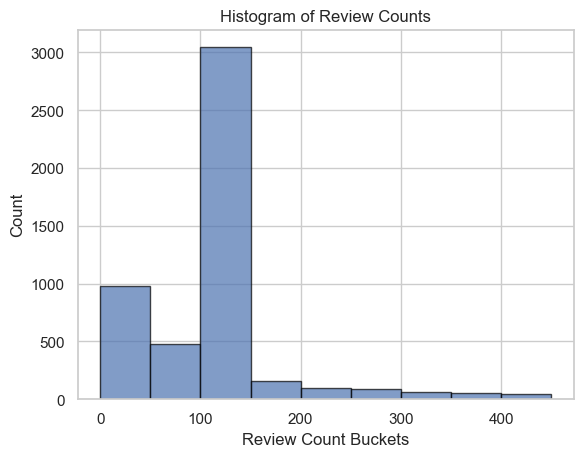

In [102]:
# plot histogram for review counts
plt.hist(df.reviewCount, bins=list(range(0,500,50)), edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Review Count Buckets')
plt.ylabel('Count')
plt.title('Histogram of Review Counts')
plt.show()

In [103]:
from itertools import chain

In [104]:
## cleaning and formating for cuisine feature
set(df.loc[df['cuisine'].notna(), 'cuisine'])

{"['European', 'Seafood', 'Breakfast and Brunch', 'French']",
 "['Mexican', 'Latin American', 'Salads', 'Chicken', 'Seafood', 'Breakfast and Brunch']",
 "['Indian', 'Indian Curry', 'Salads']",
 "['Burgers', 'Comfort Food', 'Sandwich']",
 "['Breakfast and Brunch', 'Bakery', 'Comfort Food', 'Desserts']",
 "['Sandwich', 'American', 'Burgers']",
 "['Spanish', 'Kids Friendly', 'Seafood']",
 "['Italian', 'Pasta', 'American', 'Comfort Food', 'Vegetarian Friendly', 'Noodles', 'Kids Friendly', 'European']",
 "['Grocery', 'Convenience', 'Desserts', 'Snacks', 'Breakfast and Brunch', 'Sandwich', 'Wings', 'Everyday Essentials', 'Home & Personal Care']",
 "['Cafe', 'Breakfast and Brunch', 'American', 'Sandwich']",
 "['American', 'Burgers', 'Sandwich']",
 "['Steak', 'American']",
 "['Italian', 'Pizza', 'Pasta', 'Burgers', 'Sandwich']",
 "['Bakery', 'Breakfast and Brunch', 'Desserts']",
 "['Chinese', 'Asian', 'FriedRice']",
 "['Cuban']",
 "['Cajun', 'Haitian']",
 "['Asian', 'Desserts', 'Juice and Smoo

In [105]:
import ast

In [106]:
df = df.dropna(axis=0)
df['cuisine'] = df['cuisine'].apply(ast.literal_eval)

/var/folders/qw/w_wymrtd43767cxrkt3gkr0r0000gn/T/ipykernel_97628/2430375781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cuisine'] = df['cuisine'].apply(ast.literal_eval)


In [107]:
df.shape

(4652, 16)

In [108]:
# create a new feature column based on number of cuisines each restaurant provides
df['cuisine_types'] = df['cuisine'].apply(len)

/var/folders/qw/w_wymrtd43767cxrkt3gkr0r0000gn/T/ipykernel_97628/2843467050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cuisine_types'] = df['cuisine'].apply(len)


In [109]:
set(chain(*df['cuisine']))

{'Afghan',
 'African',
 'African: Other',
 'Alcohol',
 'Allergy Friendly',
 'American',
 'Arabian',
 'Argentinian',
 'Armenian',
 'Asian',
 'Asian Fusion',
 'Asian: Other',
 'Australian',
 'Austrian',
 'BBQ',
 'BREAKfastAndBrunch',
 'Bakery',
 'Bangladeshi',
 'Bar / Pub Food',
 'Bar Food',
 'Belgian',
 'Biryani',
 'Brazilian',
 'Breakfast',
 'Breakfast & Brunch',
 'Breakfast and Brunch',
 'British',
 'Brunch',
 'Bubble Tea',
 'Burgers',
 'Burritos',
 'Cafe',
 'Cajun',
 'Cambodian',
 'Cantonese',
 'Caribbean',
 'Chicken',
 'Chicken Strips',
 'ChickenRice',
 'Chilean',
 'Chinese',
 'Chinese Food',
 'Chinese: Cantonese',
 'Chinese: Noodles & Dumplings',
 'Chinese: Other',
 'Chinese: Sichuan',
 'Chinese: Taiwanese',
 'ChineseNoodles',
 'Coffee & Tea',
 'Coffee and Tea',
 'Colombian',
 'Comfort Food',
 'CongeeBoilRice',
 'Convenience',
 'Cuban',
 'Cupcakes',
 'Curry',
 'CurryRice',
 'Danish',
 'Deli',
 'Dessert: Other',
 'Desserts',
 'Diner',
 'Dinner',
 'Dominican',
 'Donuts',
 'Dumplings'

In [110]:
# more cleaning for cuisines
def lower_case(x):
    return [i.lower() for i in x]
df['cuisine'] = df['cuisine'].apply(lower_case)

/var/folders/qw/w_wymrtd43767cxrkt3gkr0r0000gn/T/ipykernel_97628/2564162413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cuisine'] = df['cuisine'].apply(lower_case)


In [111]:
# merge cuisines with same prefix
def remove_duplicates_with_same_prefix(lst):
    result = {}
    
    for string in lst:
        prefix = next((key for key in result if string.startswith(key)), None)
        
        if prefix is not None:
            if len(string) < len(result[prefix]):
                result[prefix] = string
        else:
            st = string.split(' ')[0]
            result[st] = st 

    return list(result.values())

In [112]:
cuisines = remove_duplicates_with_same_prefix(sorted(list(set(chain(*df['cuisine'])))))

In [113]:
# normalise the cuisines
def normalise_cuisins(x):
    return [i for i in cuisines for j in x if j.startswith(i)]
        
df['cuisine'] = df['cuisine'].apply(normalise_cuisins)

/var/folders/qw/w_wymrtd43767cxrkt3gkr0r0000gn/T/ipykernel_97628/166085296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cuisine'] = df['cuisine'].apply(normalise_cuisins)


In [114]:
df_exploded = df.explode('cuisine')

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

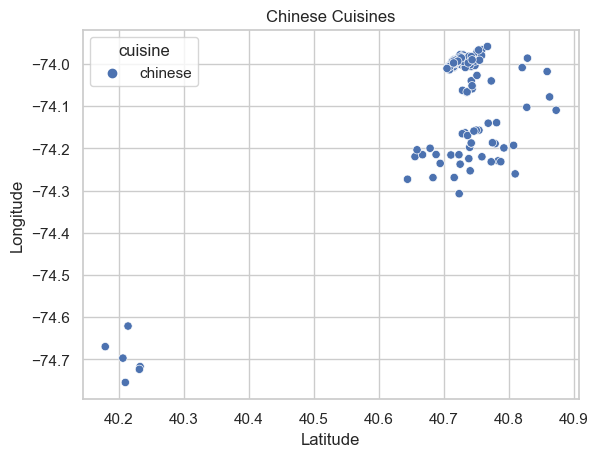

In [115]:
# plot graph to visualise the chinese restaurants by location
df_filtered = df_exploded[df_exploded['cuisine'].isin(['chinese'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Chinese Cuisines')
plt.savefig('plots/chinese_cuisine_distribution.png')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

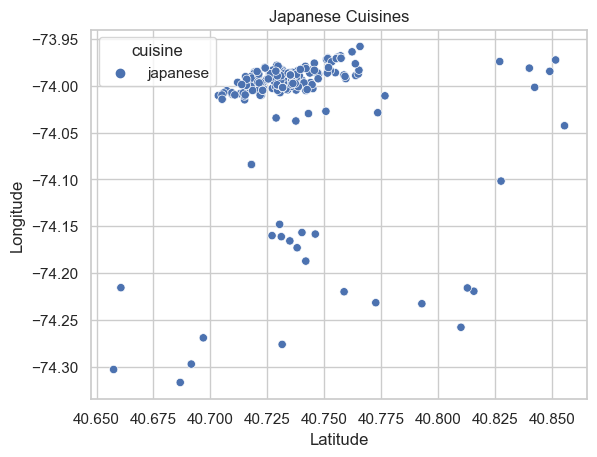

In [116]:
# plot graph to visualise the japanes restaurants by location
df_filtered = df_exploded[df_exploded['cuisine'].isin(['japanese'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Japanese Cuisines')
plt.savefig('plots/japanese_cuisine_distribution.png')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

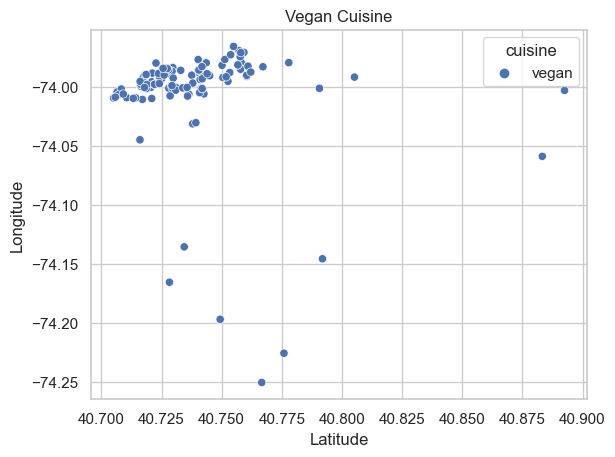

In [117]:
# plot graph to visualise the vegan restaurants by location
df_filtered = df_exploded[df_exploded['cuisine'].isin([ 'vegan'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Vegan Cuisine')
plt.savefig('plots/vegan_cuisine_distribution.png')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

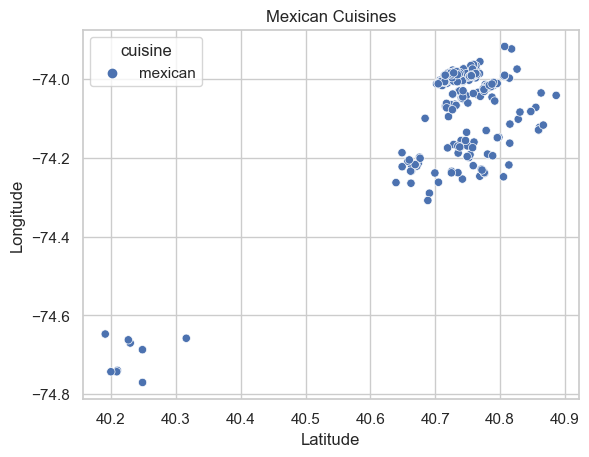

In [118]:
# plot graph to visualise the mexican restaurants by location
df_filtered = df_exploded[df_exploded['cuisine'].isin(['mexican'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Mexican Cuisines')
plt.savefig('plots/mexican_cuisine_distribution.png')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

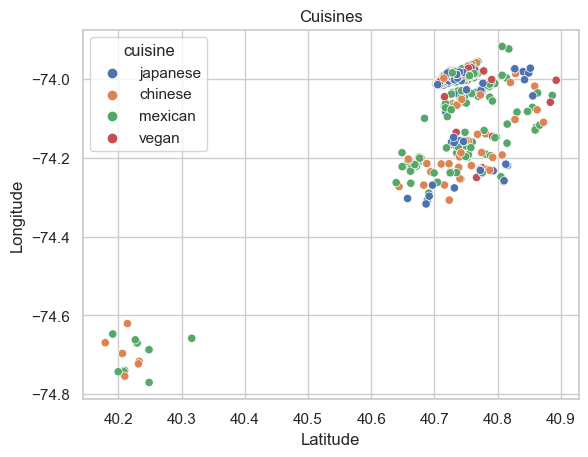

In [119]:
# plot graph to visualise the restaurants by location and cuisine
df_filtered = df_exploded[df_exploded['cuisine'].isin(['chinese', 'japanese', 'vegan', 'mexican'])]

sb.scatterplot(data=df_filtered, x='latitude', y='longitude', hue='cuisine')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Cuisines')
plt.savefig('plots/cuisines.png')
plt.show()

In [120]:
df_dummies = pd.get_dummies(df_exploded['cuisine'], prefix='').groupby(level=0).sum()
df_result = pd.concat([df, df_dummies], axis=1)
df_result = df_result.drop('cuisine', axis=1)

In [121]:
df_result.describe()

,ratingValue,reviewCount,priceRange,latitude,longitude,cuisine_types,_afghan,_african,_alcohol,_allergy,...,_traditional,_turkish,_vegan,_vegetarian,_venezuelan,_vietnamese,_west,_whatever,_wings,_wraps
count,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,...,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000
mean,4.515611,132.717637,1.230224,40.725458,-74.059734,3.157997,0.000430,0.004729,0.000645,0.024936,...,0.007524,0.003224,0.027300,0.092648,0.000430,0.007094,0.001505,0.000645,0.044712,0.000430
std,0.204469,99.947998,0.531613,0.097441,0.144937,1.336750,0.020732,0.068613,0.025389,0.155945,...,0.086421,0.056698,0.175672,0.304439,0.020732,0.083934,0.038766,0.025389,0.206693,0.020732
min,2.700000,10.000000,0.000000,40.070888,-74.855080,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.513425,79.750000,1.000000,40.721655,-74.063913,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.513425,132.510391,1.000000,40.735934,-73.999916,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.513425,132.510391,1.000000,40.756092,-73.987487,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,500.000000,4.000000,40.909039,-73.908490,20.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


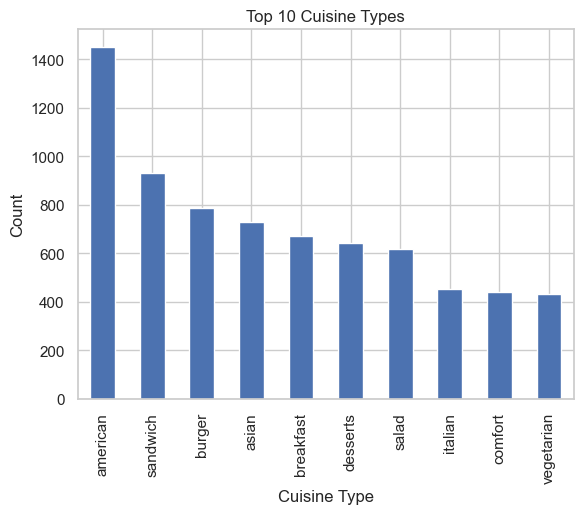

In [122]:
cuisine_counts = df_exploded['cuisine'].value_counts()

# Select the top 10 cuisine types
top_cuisines = cuisine_counts.head(10)

# Plot a bar graph
top_cuisines.plot(kind='bar')
plt.xlabel('Cuisine Type')
plt.ylabel('Count')
plt.title('Top 10 Cuisine Types')
plt.savefig('plots/top_10_cuisines.png')
plt.show()

In [123]:
count = []
new_cuisines = []
for ci in ["_"+x for x in cuisines]:
    val = df_result[ci].sum()
    if val >= 10:
        new_cuisines.append(ci)
        count.append(val)
    print(f"Freq {ci}: {df_result[ci].sum()}")

Freq _afghan: 2
Freq _african: 22
Freq _alcohol: 3
Freq _allergy: 116
Freq _american: 1450
Freq _arabian: 13
Freq _argentinian: 8
Freq _armenian: 1
Freq _asian: 730
Freq _australian: 4
Freq _austrian: 1
Freq _bakery: 146
Freq _bangladeshi: 2
Freq _bar: 62
Freq _bbq: 97
Freq _belgian: 6
Freq _biryani: 1
Freq _brazilian: 29
Freq _breakfast: 672
Freq _british: 1
Freq _brunch: 1
Freq _bubble: 55
Freq _burger: 786
Freq _burritos: 38
Freq _cafe: 107
Freq _cajun: 9
Freq _cambodian: 2
Freq _cantonese: 7
Freq _caribbean: 55
Freq _chicken: 249
Freq _chilean: 1
Freq _chinese: 215
Freq _chocolatier: 13
Freq _coffee: 224
Freq _colombian: 18
Freq _comfort: 442
Freq _congeeboilrice: 2
Freq _convenience: 17
Freq _cuban: 38
Freq _cupcakes: 19
Freq _curry: 9
Freq _danish: 1
Freq _deli: 86
Freq _dessert:: 3
Freq _desserts: 641
Freq _diner: 48
Freq _dinner: 13
Freq _dominican: 11
Freq _donuts: 196
Freq _dumplings: 3
Freq _eastern: 4
Freq _egyptian: 2
Freq _ethiopian: 3
Freq _european: 35
Freq _everyday: 1

In [124]:
df = df_result
geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

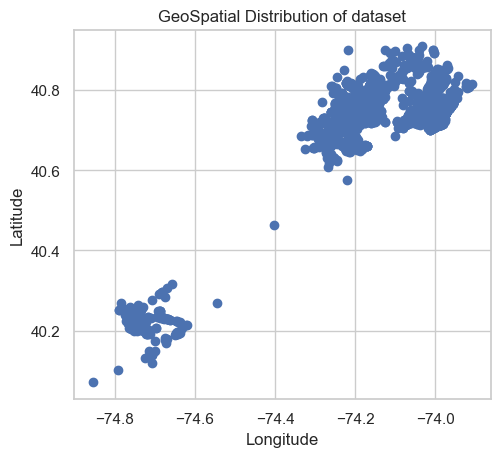

In [125]:
gdf.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GeoSpatial Distribution of dataset')
plt.savefig('plots/geospatial_dataset.png')
plt.show()

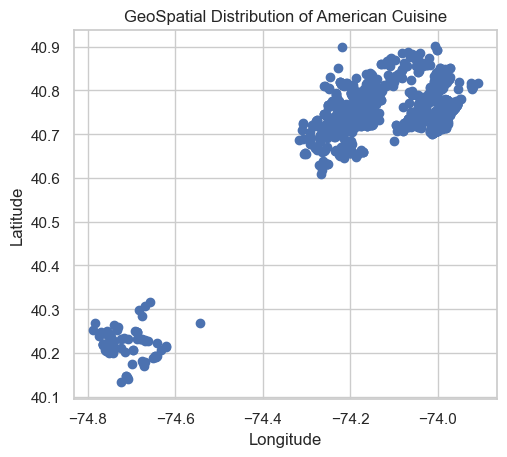

In [126]:
american = df[df['_american'] == 0]
geometry = gpd.points_from_xy(american['longitude'], american['latitude'])
gdf = gpd.GeoDataFrame(american, geometry=geometry)
gdf.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GeoSpatial Distribution of American Cuisine')
plt.savefig('plots/american_cuisine.png')
plt.show()


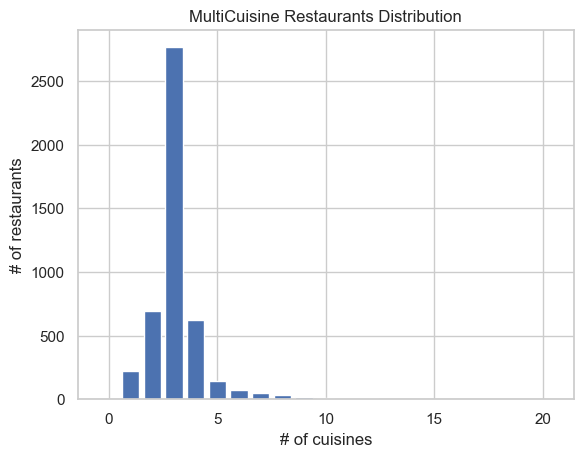

In [127]:
# plot graph for restaurants distribution by cusine count 
cuisine_types = df['cuisine_types'].value_counts().sort_index()
plt.bar(cuisine_types.index, cuisine_types)
plt.xlabel('# of cuisines')
plt.ylabel('# of restaurants')
plt.title('MultiCuisine Restaurants Distribution')
plt.savefig('plots/cuisines_counts.png')
plt.show()

In [128]:
df.describe()

,ratingValue,reviewCount,priceRange,latitude,longitude,cuisine_types,_afghan,_african,_alcohol,_allergy,...,_traditional,_turkish,_vegan,_vegetarian,_venezuelan,_vietnamese,_west,_whatever,_wings,_wraps
count,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,...,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000,4652.000000
mean,4.515611,132.717637,1.230224,40.725458,-74.059734,3.157997,0.000430,0.004729,0.000645,0.024936,...,0.007524,0.003224,0.027300,0.092648,0.000430,0.007094,0.001505,0.000645,0.044712,0.000430
std,0.204469,99.947998,0.531613,0.097441,0.144937,1.336750,0.020732,0.068613,0.025389,0.155945,...,0.086421,0.056698,0.175672,0.304439,0.020732,0.083934,0.038766,0.025389,0.206693,0.020732
min,2.700000,10.000000,0.000000,40.070888,-74.855080,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.513425,79.750000,1.000000,40.721655,-74.063913,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.513425,132.510391,1.000000,40.735934,-73.999916,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.513425,132.510391,1.000000,40.756092,-73.987487,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,500.000000,4.000000,40.909039,-73.908490,20.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
# remove outliers
df = df[df['cuisine_types'] <= 8]
df = df[df['cuisine_types'] > 0]
df = df[df['priceRange'] > 0]

In [130]:
# drop unused features
df = df.drop(columns=['name', 'url', 'city', 'streetAddress', 'postalCode', 'addressLocality', 'addressRegion', 'openingHoursSpecification', 'addressString', 'geoString'])

In [131]:
df.select_dtypes(include='object').columns


Index([], dtype='object')

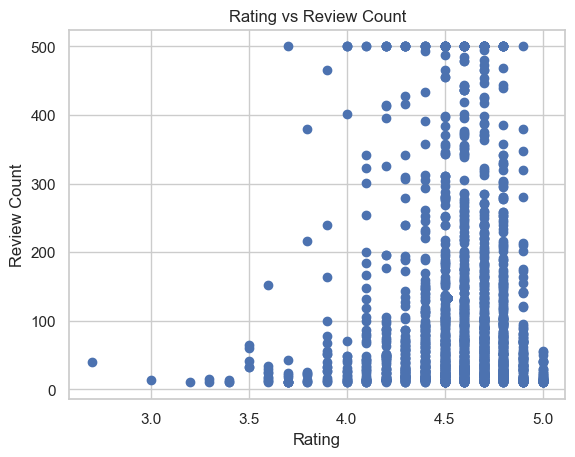

In [132]:

corr_columns = ['ratingValue', 'reviewCount', 'priceRange']

# plot graph for ratings & reviews for american cuisine
plt.scatter(american['ratingValue'], american['reviewCount'])
plt.xlabel('Rating')
plt.ylabel('Review Count')
plt.title('Rating vs Review Count')
plt.savefig('plots/rating_review_count.png')
plt.show()

In [133]:
# view correlation matrix of all features
df.corr()

,ratingValue,reviewCount,priceRange,latitude,longitude,cuisine_types,_afghan,_african,_alcohol,_allergy,...,_traditional,_turkish,_vegan,_vegetarian,_venezuelan,_vietnamese,_west,_whatever,_wings,_wraps
ratingValue,1.000000,-0.000779,0.072250,0.073711,0.108743,0.016678,-0.000234,-0.006265,-0.000286,0.006356,...,-0.004783,0.005843,0.052163,0.046777,0.009320,0.022461,-0.007719,NaN,-0.120665,-0.000234
reviewCount,-0.000779,1.000000,-0.008399,0.089068,-0.059790,0.026044,-0.000055,-0.029489,-0.000067,-0.045387,...,0.003711,-0.017469,-0.045127,-0.070069,-0.009812,-0.035442,0.004716,NaN,0.079585,-0.000055
priceRange,0.072250,-0.008399,1.000000,0.052161,0.072781,-0.041812,0.009800,-0.025388,0.003118,0.000427,...,0.039079,0.022898,0.003429,-0.006043,-0.011963,-0.005565,0.008616,NaN,0.014800,0.009800
latitude,0.073711,0.089068,0.052161,1.000000,0.780127,-0.002344,0.004984,0.002714,0.002477,0.020636,...,-0.002303,0.022843,0.023662,0.006229,0.001179,0.003516,0.007595,NaN,-0.057434,0.000008
longitude,0.108743,-0.059790,0.072781,0.780127,1.000000,0.009870,0.012579,-0.033669,0.011809,0.000709,...,0.004130,0.028115,0.054322,0.066159,0.009682,0.032684,-0.022449,NaN,-0.114038,0.008483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_vietnamese,0.022461,-0.035442,-0.005565,0.003516,0.032684,0.001221,-0.001719,-0.005582,-0.002106,0.024198,...,-0.006334,-0.004714,-0.012467,-0.015075,-0.001719,1.000000,-0.002719,NaN,-0.017167,-0.001719
_west,-0.007719,0.004716,0.008616,0.007595,-0.022449,0.028922,-0.000712,0.095565,-0.000872,-0.005218,...,-0.002623,-0.001952,-0.005163,-0.010186,-0.000712,-0.002719,1.000000,NaN,-0.007109,-0.000712
_whatever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_wings,-0.120665,0.079585,0.014800,-0.057434,-0.114038,0.130228,-0.004495,-0.014596,-0.005505,-0.011036,...,0.011994,-0.012327,-0.025824,-0.045414,-0.004495,-0.017167,-0.007109,NaN,1.000000,-0.004495


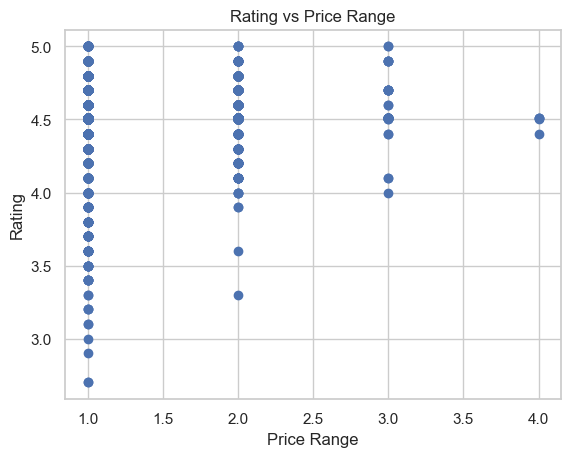

In [134]:
# plot graph for price range and rating
plt.scatter(df['priceRange'], df['ratingValue'])

plt.ylabel('Rating')
plt.xlabel('Price Range')
plt.title('Rating vs Price Range')
plt.savefig('plots/rating_price_range.png')
plt.show()

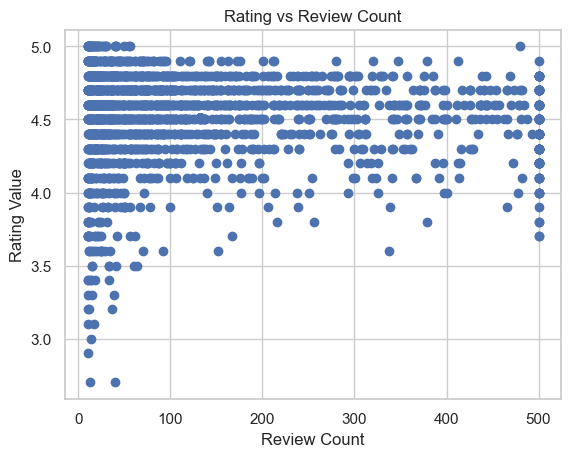

In [135]:
# plot graph for review counts and rating
plt.scatter(df['reviewCount'], df['ratingValue'])

plt.ylabel('Rating Value')
plt.xlabel('Review Count')
plt.title('Rating vs Review Count')
plt.savefig('plots/rating_review_count.png')
plt.show()

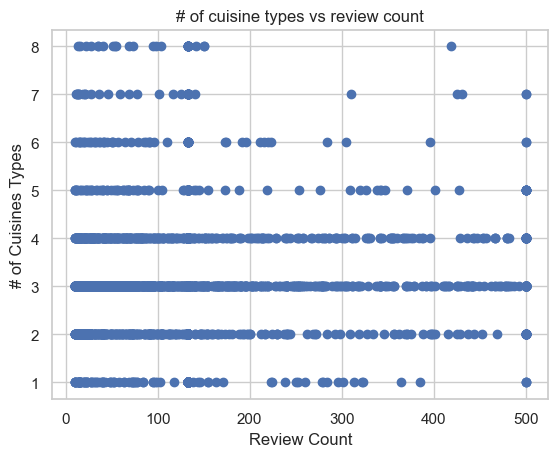

In [136]:
# plot graph for review counts and cuisine types
plt.scatter(df['reviewCount'], df['cuisine_types'])

plt.ylabel('# of Cuisines Types')
plt.xlabel('Review Count')
plt.title('# of cuisine types vs review count')
plt.savefig('plots/cuisines_review_counts.png')
plt.show()

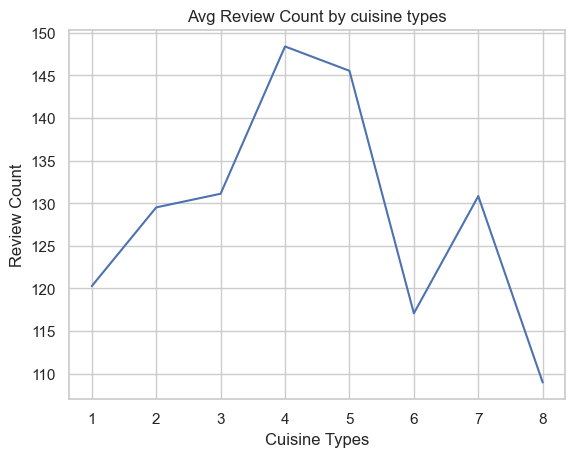

In [137]:
grouped_df = df.groupby('cuisine_types')['reviewCount'].mean().reset_index()


# Plot the graph for avg review counts by cuisine count
plt.plot(grouped_df['cuisine_types'], grouped_df['reviewCount'])

# Add title and labels
plt.title('Avg Review Count by cuisine types')
plt.xlabel('Cuisine Types')
plt.ylabel('Review Count')
plt.savefig('plots/avg_review_count_by_cuisine_types.png')
plt.show()

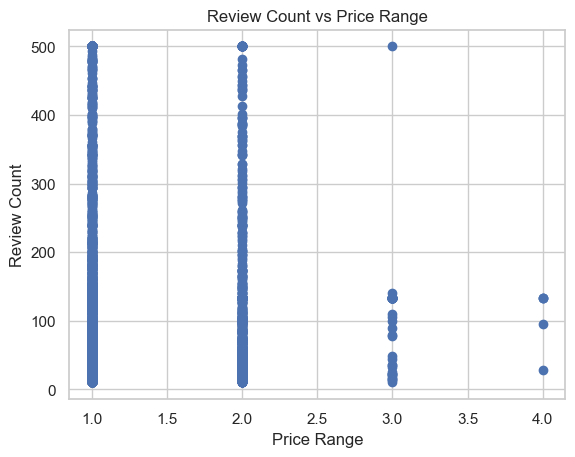

In [138]:
# plot graph for price range and review counts
plt.scatter(df['priceRange'], df['reviewCount'])
plt.ylabel('Review Count')
plt.xlabel('Price Range')
plt.title('Review Count vs Price Range')
plt.savefig('plots/price_range_review_count.png')
plt.show()

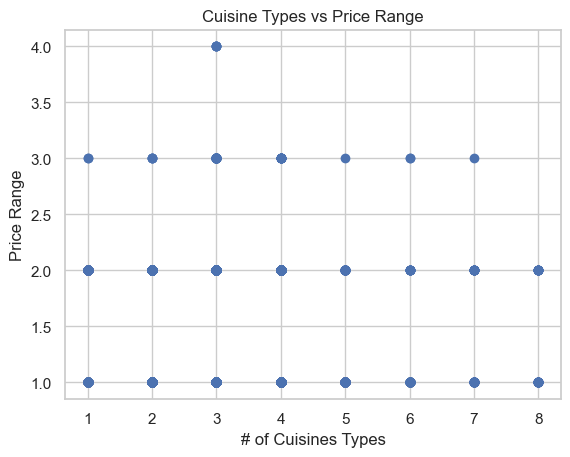

In [139]:
# plot for cuisine types and price range
plt.scatter(df['cuisine_types'], df['priceRange'])

plt.xlabel('# of Cuisines Types')
plt.ylabel('Price Range')
plt.title('Cuisine Types vs Price Range')
plt.savefig('plots/price_range_cuisine_types.png')
plt.show()

In [140]:
# normalise the features
df_norm = (df - df.min()) / (df.max() - df.min())

In [141]:
corr_columns = ['ratingValue', 'reviewCount', 'priceRange', 'cuisine_types']
corr_matrix = df_norm[corr_columns].corr()

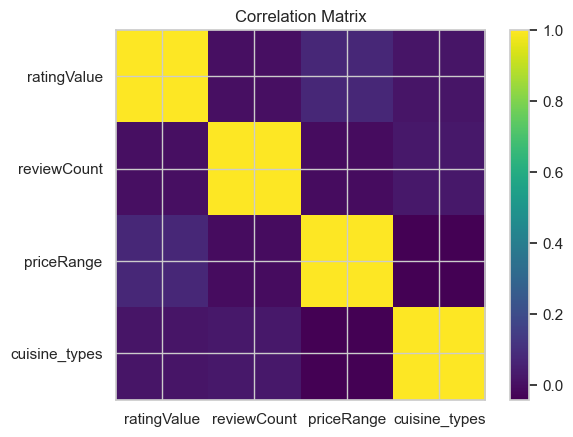

In [142]:
# plot correlation matrix for selected features
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_columns)), corr_columns)
plt.yticks(range(len(corr_columns)), corr_columns)
plt.title('Correlation Matrix')
plt.savefig('plots/correlation_matrix.png')
plt.show()

In [143]:
# Phase 2
df

,ratingValue,reviewCount,priceRange,latitude,longitude,cuisine_types,_afghan,_african,_alcohol,_allergy,...,_traditional,_turkish,_vegan,_vegetarian,_venezuelan,_vietnamese,_west,_whatever,_wings,_wraps
0,4.513425,132.510391,1,40.752349,-73.975021,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.100000,39.000000,1,40.762923,-73.985342,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.513425,132.510391,1,40.707828,-74.005660,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.513425,132.510391,1,40.721287,-74.004971,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.513425,132.510391,1,40.740975,-74.004635,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,4.400000,262.000000,2,40.758398,-74.219813,3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5202,4.500000,190.000000,1,40.778459,-74.176245,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5203,4.513425,132.510391,1,40.757419,-74.167163,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5204,4.200000,88.000000,1,40.730331,-74.061955,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Coefficients: 
 [-8.74750899e-06  2.58458739e-02 -5.83973745e-02  1.90658002e-01
  6.77724406e-03]
Mean squared error: 0.053066
Coefficient of determination: 0.004560


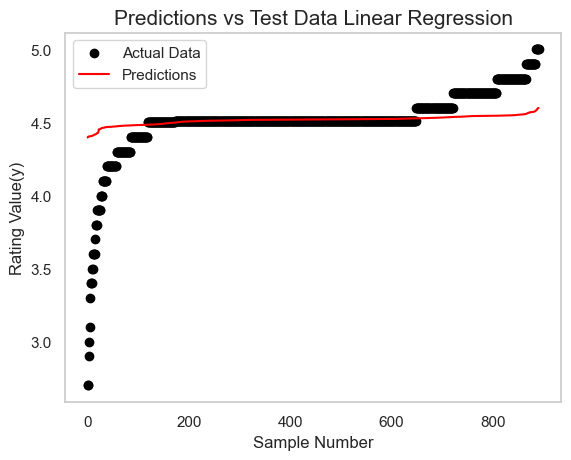

In [144]:
# Linear Regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# dropped the extracted cuisine columns as they were very sparse
X = df[['reviewCount', 'priceRange','latitude', 'longitude', 'cuisine_types'] ]

# predicting the rating value
y = df['ratingValue']

def Regression(X, y):
    # split to training, testing with 80,20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # create, train, and predict using linear regression (OLS so no hyperparameters to tune)
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # Evaluate
    # The coefficients
    print("Coefficients: \n", reg.coef_)
    # The mean squared error
    print("Mean squared error: %f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %f" % r2_score(y_test, y_pred))

    # Plot outputs -- actual test data and predictions
    plt.scatter(np.linspace(0,len(y_test),len(y_test)), sorted(y_test), color="black", label='Actual Data')
    plt.plot(np.linspace(0,len(y_test),len(y_test)), sorted(y_pred), color="red", label='Predictions')
    plt.grid()
    plt.ylabel('Rating Value(y)', fontsize=12)
    plt.xlabel('Sample Number', fontsize=12)
    plt.title('Predictions vs Test Data Linear Regression', fontsize=15)
    plt.legend()
    plt.show()
    return reg

reg = Regression(X, y)

Coefficients: 
 [-2.24426052e-05  2.04342366e-02  0.00000000e+00  8.46115634e-02
  5.46754130e-03]
Mean squared error: 0.053031
Coefficient of determination: 0.005215


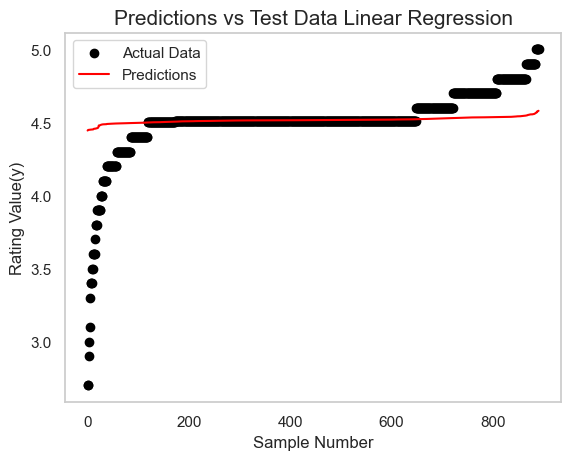

[I 2023-11-10 23:14:03,755] A new study created in memory with name: no-name-1d4b341c-5420-4374-af50-a4a7e1a2deec
[I 2023-11-10 23:14:03,786] Trial 0 finished with value: -3.4203750907124686e-06 and parameters: {'alpha': 0.43688183664043245}. Best is trial 0 with value: -3.4203750907124686e-06.
[I 2023-11-10 23:14:03,796] Trial 1 finished with value: -3.4203750907124686e-06 and parameters: {'alpha': 0.8027296485801968}. Best is trial 0 with value: -3.4203750907124686e-06.
[I 2023-11-10 23:14:03,805] Trial 2 finished with value: -0.00045705058402556453 and parameters: {'alpha': 0.17485752561300494}. Best is trial 0 with value: -3.4203750907124686e-06.
[I 2023-11-10 23:14:03,811] Trial 3 finished with value: -3.4203750907124686e-06 and parameters: {'alpha': 0.5856529322487197}. Best is trial 0 with value: -3.4203750907124686e-06.
[I 2023-11-10 23:14:03,824] Trial 4 finished with value: -3.4203750907124686e-06 and parameters: {'alpha': 0.3555657876969447}. Best is trial 0 with value: -3.4

In [145]:
# Lasso Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

X = df[['reviewCount', 'priceRange','latitude', 'longitude', 'cuisine_types'] ]
y = df['ratingValue']

def LassoRegression(X, y):
    # same X and y for this regression as well and same dataset split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # created, trained, and predicted using Lasso regression,
    # and alpha value found using optuna hyper parameter tuning
    las = Lasso(alpha = 0.0016151558561492921, warm_start = True)
    las.fit(X_train,y_train)
    y_pred = las.predict(X_test)
    # evaluate and plot predictions and actual data points
    # The coefficients
    print("Coefficients: \n", las.coef_)
    # The mean squared error
    print("Mean squared error: %f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %f" % r2_score(y_test, y_pred))

    # Plot outputs
    plt.scatter(np.linspace(0,len(y_test),len(y_test)), sorted(y_test), color="black", label='Actual Data')
    plt.plot(np.linspace(0,len(y_test),len(y_test)), sorted(y_pred), color="red", label='Predictions')
    plt.grid()
    plt.ylabel('Rating Value(y)', fontsize=12)
    plt.xlabel('Sample Number', fontsize=12)
    plt.title('Predictions vs Test Data Linear Regression', fontsize=15)
    plt.legend()
    plt.show()
    return las

las = LassoRegression(X, y)

# same X and y for this regression as well and same dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# optuna tuning to find optimal alpha value by maximizing r2 score
# MSE was actually pretty good as most of the data points are centralized
# want to get r2 score closer to 1
def objective(trail):
  alpha = trail.suggest_float("alpha", 0, 1)

  las_op = Lasso(alpha=alpha,warm_start = True)
  las_op.fit(X_train,y_train)
  y_pred = las_op.predict(X_test)


  r2 = r2_score(y_test,y_pred)

  return r2

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-11-10 23:14:05,169] A new study created in memory with name: no-name-e8a94319-ddda-4a2e-a19b-b74966cb4292


[I 2023-11-10 23:14:05,602] Trial 0 finished with value: 0.05252256627633667 and parameters: {'alpha': 64780.9347786676}. Best is trial 0 with value: 0.05252256627633667.
[I 2023-11-10 23:14:06,130] Trial 1 finished with value: 0.0504748439635878 and parameters: {'alpha': 6381.948546697429}. Best is trial 1 with value: 0.0504748439635878.
[I 2023-11-10 23:14:06,664] Trial 2 finished with value: 0.05158159891097385 and parameters: {'alpha': 21645.769728422238}. Best is trial 1 with value: 0.0504748439635878.
[I 2023-11-10 23:14:07,210] Trial 3 finished with value: 0.05059518515342916 and parameters: {'alpha': 7624.445749823427}. Best is trial 1 with value: 0.0504748439635878.
[I 2023-11-10 23:14:07,728] Trial 4 finished with value: 0.05275024639031856 and parameters: {'alpha': 96765.35697203908}. Best is trial 1 with value: 0.0504748439635878.
[I 2023-11-10 23:14:08,280] Trial 5 finished with value: 0.05267549217263163 and parameters: {'alpha': 83738.79501667076}. Best is trial 1 with v

Best alpha: 2807.0968920350015
Mean Squared Error: 0.050226108468924724
Coefficient of determination: 0.057839


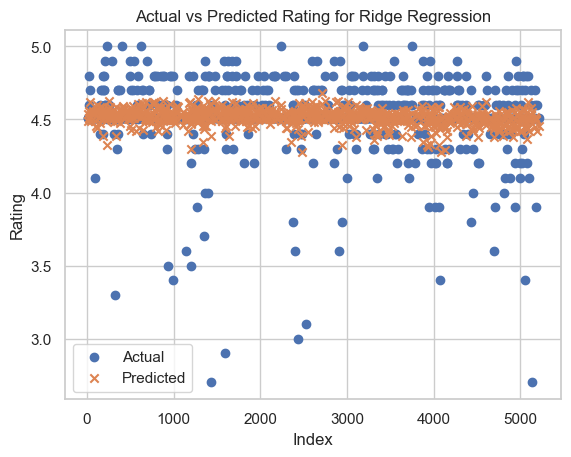

In [146]:
# Ridge Regression

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import optuna

X = df.drop(['ratingValue'], axis=1)
y = df['ratingValue']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    # alpha hyperparameter search space
    alpha = trial.suggest_float('alpha', 1e-5, 1e5)
    
    # Ridge regression model
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = ridge_reg.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    return mse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# best hyperparameters
best_params = study.best_params
best_alpha = best_params['alpha']

print(f'Best alpha: {best_alpha}')

# train the Ridge regression model again with the best alpha
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train_scaled, y_train)

# predictions on the test set
y_pred = best_ridge_model.predict(X_test_scaled)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print("Coefficient of determination: %f" % r2_score(y_test, y_pred))
joblib.dump(best_ridge_model, 'best_ridge_model.pkl')

plt.scatter(y_test.index, y_test, label='Actual', marker='o')
plt.scatter(y_test.index, y_pred, label=f'Predicted',marker='x')

plt.xlabel('Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Rating for Ridge Regression')
plt.legend()
plt.show()


[I 2023-11-10 23:14:57,799] A new study created in memory with name: no-name-f849ce38-7619-4556-a1b3-ac99a4afb8fb
[I 2023-11-10 23:14:57,936] Trial 0 finished with value: 0.05330965836713891 and parameters: {'alpha': 60740.053247395765}. Best is trial 0 with value: 0.05330965836713891.
[I 2023-11-10 23:14:58,075] Trial 1 finished with value: 0.05330965836713891 and parameters: {'alpha': 9520.445343695343}. Best is trial 0 with value: 0.05330965836713891.
[I 2023-11-10 23:14:58,173] Trial 2 finished with value: 0.05330965836713891 and parameters: {'alpha': 48577.789388326266}. Best is trial 0 with value: 0.05330965836713891.
[I 2023-11-10 23:14:58,269] Trial 3 finished with value: 0.05330965836713891 and parameters: {'alpha': 81269.02851358986}. Best is trial 0 with value: 0.05330965836713891.
[I 2023-11-10 23:14:58,330] Trial 4 finished with value: 0.05330965836713891 and parameters: {'alpha': 53072.82489003626}. Best is trial 0 with value: 0.05330965836713891.
[I 2023-11-10 23:14:58,4

Best Alpha: 60740.053247395765
Best Mean Squared Error: 0.05330965836713891
Coefficient of determination: -0.000003


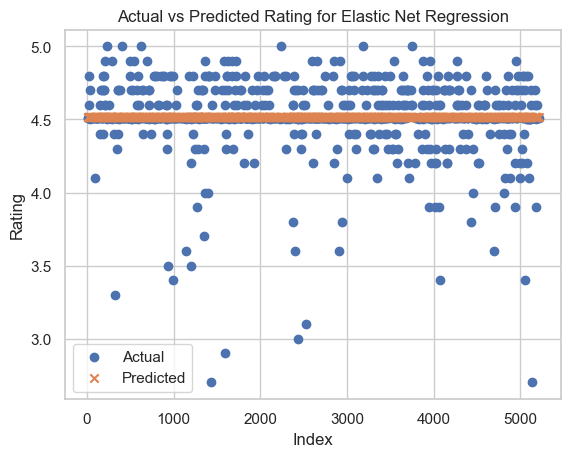

In [147]:
from sklearn.linear_model import ElasticNet

best_alpha = None
best_mse = float('inf')
best_elastic_net_model = None


# range of alpha values on a logarithmic scale
alphas = np.logspace(-3, 3, 7)


def objective(trail):
    alpha = trail.suggest_float('alpha', 1e-5, 1e5)
    # Create and train the Elastic Net model with the current alpha
    elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=0.5)  # l1_ratio=0.5 balances L1 and L2 regularization
    elastic_net_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = elastic_net_model.predict(X_test_scaled)

    # Calculate Mean Squared Error for each alpha
    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
best_alpha = best_params['alpha']

best_elastic_net_model = ElasticNet(alpha=best_alpha, l1_ratio=0.5)
best_elastic_net_model.fit(X_train_scaled, y_train)
y_pred = best_elastic_net_model.predict(X_test_scaled)
best_mse = mean_squared_error(y_test, y_pred)

# best alpha and corresponding Mean Squared Error
print(f'Best Alpha: {best_alpha}')
print(f'Best Mean Squared Error: {best_mse}')

# Save the best model
joblib.dump(best_elastic_net_model, 'best_elastic_net_model.pkl')

print("Coefficient of determination: %f" % r2_score(y_test, y_pred))
plt.scatter(y_test.index, y_test, label='Actual', marker='o')
plt.scatter(y_test.index, y_pred, label=f'Predicted',marker='x')

plt.xlabel('Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Rating for Elastic Net Regression')
plt.legend()
plt.show()

Epoch [1/1000], Loss: 8.5680
Epoch [101/1000], Loss: 3.3337
Epoch [201/1000], Loss: 1.1810
Epoch [301/1000], Loss: 0.4834
Epoch [401/1000], Loss: 0.2407
Epoch [501/1000], Loss: 0.1411
Epoch [601/1000], Loss: 0.0941
Epoch [701/1000], Loss: 0.0699
Epoch [801/1000], Loss: 0.0568
Epoch [901/1000], Loss: 0.0495


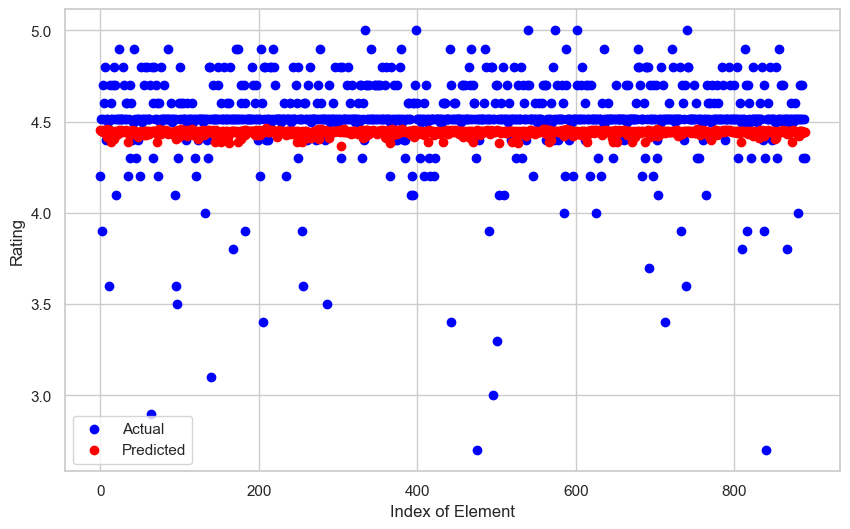

MSE on test data: 0.058499179780483246


In [148]:
# Neural Network for Rating Prediction
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

class RatingPredictor(nn.Module):
    def __init__(self):
        super(RatingPredictor, self).__init__()
        self.layer1 = nn.Linear(in_features=4, out_features=20)
        self.layer2 = nn.Linear(in_features=20, out_features=10)
        self.output_layer = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))

        # Scale the output to the rating range (0 to 5)
        x = 5 * x
        return x

def NNRatingPredictor():
    model = RatingPredictor()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    X_train, X_test, y_train, y_test = train_test_split(df[["reviewCount", "priceRange", "latitude", "longitude"]], df[["ratingValue"]], test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train.values)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test.values)
    
    running_loss = []
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
            
    # Set the model to evaluation mode
    model.eval()

    # Make predictions on the test dataset
    with torch.no_grad():
        predictions = model(X_test_tensor)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(y_test_tensor)), y_test_tensor, label='Actual', color='blue')
        plt.scatter(range(len(predictions)), predictions, label='Predicted', color='red')
        plt.xlabel('Index of Element')
        plt.ylabel('Rating')
        plt.legend()
        plt.show()

    # Compute the Mean Squared Error (MSE)
    mse = nn.MSELoss()(predictions, y_test_tensor)
    print(f"MSE on test data: {mse}")

ratingPredictor = NNRatingPredictor()

Coefficients: 
 [ 0.00000000e+00  1.45574337e-01 -1.18334927e+01 -3.80730330e+02
  1.54150308e+02 -6.01437132e-07 -2.18890033e-04 -1.30017630e-03
  1.24235618e-03 -1.23242555e-02  1.20939165e-01 -9.45493181e-02
  2.78296544e+00 -2.08269399e+00  4.66328744e-01]
Mean squared error: 0.051923
Coefficient of determination: 0.026005


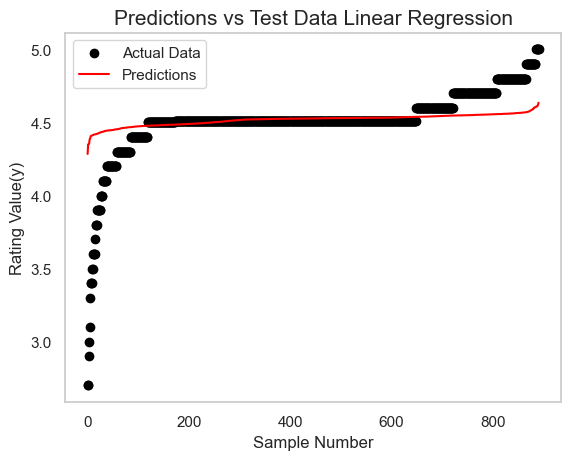

In [149]:
# Polynomial Regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# dropped the extracted cuisine columns as they were very sparse
X = df[['reviewCount', 'priceRange','latitude', 'longitude'] ]

# predicting the rating value
y = df['ratingValue']

def PolyRegression(X, y, degree):
    # split to training, testing with 80,20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # create, train, and predict using polynomial regression (OLS so no hyperparameters to tune)
    polynomial_features= PolynomialFeatures(degree=degree)
    x2_train = polynomial_features.fit_transform(X_train)
    x2_test = polynomial_features.fit_transform(X_test)

    mreg = LinearRegression().fit(x2_train, y_train)
    y_pred = mreg.predict(x2_test)

    # Evaluate
    # The coefficients
    print("Coefficients: \n", mreg.coef_)
    # The mean squared error
    print("Mean squared error: %f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %f" % r2_score(y_test, y_pred))

    # Plot outputs -- actual test data and predictions
    plt.scatter(np.linspace(0,len(y_test),len(y_test)), sorted(y_test), color="black", label='Actual Data')
    plt.plot(np.linspace(0,len(y_test),len(y_test)), sorted(y_pred), color="red", label='Predictions')
    plt.grid()
    plt.ylabel('Rating Value(y)', fontsize=12)
    plt.xlabel('Sample Number', fontsize=12)
    plt.title('Predictions vs Test Data Linear Regression', fontsize=15)
    plt.legend()
    plt.show()
    return reg

mreg = PolyRegression(X, y, degree= 2)

Coefficients: 
 [-3.95633882e-01  6.14272838e+00  1.89984688e+03  7.31867405e+04
 -5.27778682e+04  8.07106840e-04  5.72907280e-02  1.67782708e-01
  2.63071303e-01  2.82179705e+01  7.91153533e+00  5.69213546e+01
 -9.78955023e+02  9.07291977e+02 -4.62887117e+02  2.54650785e-09
  2.12573778e-06 -7.18707124e-06  7.01110523e-06 -3.60314692e-04
 -2.23227816e-03 -4.53295740e-04  7.50509840e-04  2.99137850e-03
  2.60462964e-03 -3.27995270e-03  1.09727298e-01  4.40894147e-01
 -5.58529499e-01 -5.05198370e-01  2.54555214e-01  5.39418530e+00
 -4.39001348e+00  3.72334746e+00 -1.39731606e+00]
Mean squared error: 0.051889
Coefficient of determination: 0.026642


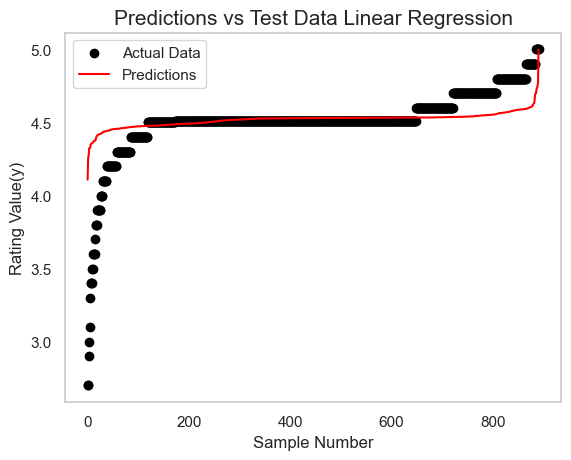

In [150]:
mreg = PolyRegression(X, y, degree= 3)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.3894878706199461


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: [0.         0.         0.         0.         0.         0.
 0.25       0.         0.         0.40412979]
Recall: [0.         0.         0.         0.         0.         0.
 0.13513514 0.         0.         0.96819788]
F1-Score: [0.         0.         0.         0.         0.         0.
 0.1754386  0.         0.         0.57023933]
Accuracy: 38.94878706199461


[Text(0.5, 20.049999999999997, 'True Cuisine'),
 Text(47.25, 0.5, 'Predicted Cuisine')]

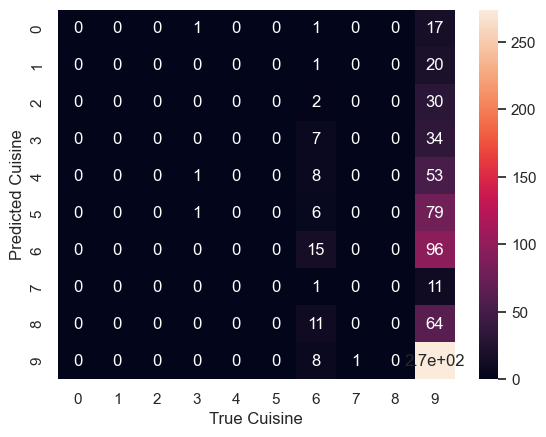

In [151]:
# Classification 

## Logistic Regression 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# top 10 cuisines as the classification models will be used to predict the most likely cuisine given features
cuisines1 = df[['_american','_sandwich','_burger', '_asian', '_breakfast','_desserts','_salad','_italian','_comfort','_vegetarian']]

# get rid of rows that do not have these cuisines
cuisines_empty = cuisines1.sum(axis=1)

top_10_df = df[['ratingValue','reviewCount','priceRange','latitude','longitude','_american','_sandwich','_burger', '_asian', '_breakfast','_desserts','_salad','_italian','_comfort','_vegetarian']]

top_10_df = top_10_df.drop(cuisines_empty[cuisines_empty ==0].index, axis=0)

# assigning each cuisine a categorical class
top_10_df['_american']= top_10_df['_american'].apply(lambda val : 9 if val > 0 else 0)
top_10_df['_sandwich']= top_10_df['_sandwich'].apply(lambda val : 8 if val > 0 else val)
top_10_df['_burger']= top_10_df['_burger'].apply(lambda val : 7 if val > 0 else val)
top_10_df['_asian']= top_10_df['_asian'].apply(lambda val : 6 if val > 0 else val)
top_10_df['_breakfast']= top_10_df['_breakfast'].apply(lambda val : 5 if val > 0 else val)
top_10_df['_desserts']= top_10_df['_desserts'].apply(lambda val : 4 if val > 0 else val)
top_10_df['_salad']= top_10_df['_salad'].apply(lambda val : 3 if val > 0 else val)
top_10_df['_italian']= top_10_df['_italian'].apply(lambda val : 2 if val > 0 else val)
top_10_df['_comfort']= top_10_df['_comfort'].apply(lambda val : 1 if val > 0 else val)
top_10_df['_vegetarian']= top_10_df['_vegetarian'].apply(lambda val : 0 if val > 0 else val)

# create new column with the categorical cuisine class types
top_10_df['cuisine']= top_10_df['_american'].apply(lambda val : 9 if val > 0 else 0)
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_sandwich'],top_10_df['cuisine'])
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_burger'],top_10_df['cuisine'])
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_asian'],top_10_df['cuisine'])
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_breakfast'],top_10_df['cuisine'])
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_desserts'],top_10_df['cuisine'])
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_salad'],top_10_df['cuisine'])
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_italian'],top_10_df['cuisine'])
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_comfort'],top_10_df['cuisine'])
top_10_df['cuisine']=np.where(top_10_df['cuisine'].eq(0),top_10_df['_vegetarian'],top_10_df['cuisine'])

# features
X = top_10_df[['ratingValue','reviewCount','priceRange','latitude','longitude']]

# predict cuisine
y = top_10_df['cuisine']
y = y.astype('int64')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create, train, and predict using Logistic regression model, and get baseline accuracy
lr = LogisticRegression(multi_class='multinomial', max_iter=1000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test,y_pred))

# optimizing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# want to maximize accuracy by tuning hyperparameters
def objective(trial):
   C = trial.suggest_float("C", 1e-7, 10.0, log=True)
   solver = trial.suggest_categorical("solver", ('newton-cg', 'sag', 'saga', 'lbfgs'))
   clf = LogisticRegression(multi_class='multinomial', C=C, solver=solver, max_iter = 1000)
   clf.fit(X_train, y_train)
   y_pred = clf.predict(X_test)
   val_accuracy = accuracy_score(y_test, y_pred)
   return val_accuracy

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000)

# create, train, and predict on optimized model
log_op = LogisticRegression(C=8.874909824652695, solver='lbfgs', multi_class='multinomial', max_iter=1000 )
log_op.fit(X_train, y_train)
y_pred = log_op.predict(X_test)

# evaluate
val_accuracy = accuracy_score(y_test, y_pred)
precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", fscore)
print("Accuracy:", val_accuracy*100)

# visualize the results -- correct classes predicted where
cf = confusion_matrix(y_test, y_pred)
ax = sb.heatmap(cf, annot=True)
ax.set(xlabel="True Cuisine", ylabel="Predicted Cuisine")


[I 2023-11-10 23:15:11,024] A new study created in memory with name: no-name-aacee45d-9e6a-4dcd-a92c-69084eea69f9
[I 2023-11-10 23:15:11,056] Trial 0 finished with value: 0.2574123989218329 and parameters: {'max_depth': 185, 'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 0 with value: 0.2574123989218329.
[I 2023-11-10 23:15:11,061] Trial 1 finished with value: 0.34097035040431267 and parameters: {'max_depth': 12, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 1 with value: 0.34097035040431267.
[I 2023-11-10 23:15:11,091] Trial 2 finished with value: 0.2574123989218329 and parameters: {'max_depth': 699, 'criterion': 'entropy', 'splitter': 'best'}. Best is trial 1 with value: 0.34097035040431267.
[I 2023-11-10 23:15:11,099] Trial 3 finished with value: 0.25202156334231807 and parameters: {'max_depth': 827, 'criterion': 'entropy', 'splitter': 'random'}. Best is trial 1 with value: 0.34097035040431267.
[I 2023-11-10 23:15:11,108] Trial 4 finished with value: 0.25606

0.2210242587601078


[I 2023-11-10 23:15:11,243] Trial 16 finished with value: 0.2587601078167116 and parameters: {'max_depth': 23, 'criterion': 'log_loss', 'splitter': 'random'}. Best is trial 14 with value: 0.35444743935309975.
[I 2023-11-10 23:15:11,256] Trial 17 finished with value: 0.2358490566037736 and parameters: {'max_depth': 41, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 14 with value: 0.35444743935309975.
[I 2023-11-10 23:15:11,276] Trial 18 finished with value: 0.3450134770889488 and parameters: {'max_depth': 10, 'criterion': 'gini', 'splitter': 'best'}. Best is trial 14 with value: 0.35444743935309975.
[I 2023-11-10 23:15:11,288] Trial 19 finished with value: 0.2857142857142857 and parameters: {'max_depth': 20, 'criterion': 'log_loss', 'splitter': 'random'}. Best is trial 14 with value: 0.35444743935309975.
[I 2023-11-10 23:15:11,298] Trial 20 finished with value: 0.25336927223719674 and parameters: {'max_depth': 106, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 14 

Accuracy: 35.44474393530997
Precision: [0.16666667 0.         0.14285714 0.         0.1        0.11111111
 0.23913043 0.66666667 0.06666667 0.40989399]
Recall: [0.05263158 0.         0.03125    0.         0.01612903 0.03488372
 0.1981982  0.16666667 0.01333333 0.81978799]
F1-Score: [0.08       0.         0.05128205 0.         0.02777778 0.05309735
 0.21674877 0.26666667 0.02222222 0.54652532]


[Text(0.5, 20.049999999999997, 'True Cuisine'),
 Text(47.25, 0.5, 'Predicted Cuisine')]

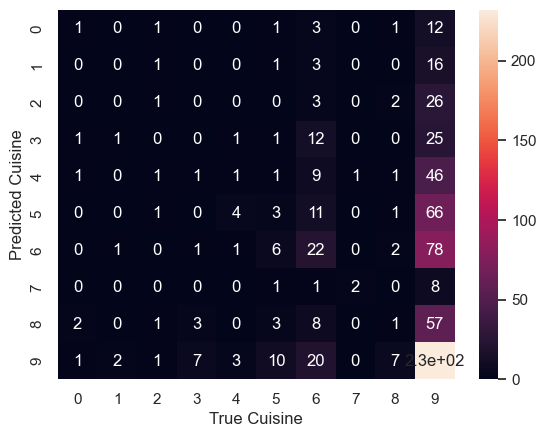

In [152]:
# Decision Trees

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# same features and target as previous classification model
X = top_10_df[['ratingValue','reviewCount','priceRange','latitude','longitude']]

y = top_10_df['cuisine']
y = y.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create, train, and predict using decision tree classifier
# get baseline accuracy
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
print(accuracy_score(y_test,y_pred))

# maximize accuracy by tuning hyperparameters
def objective(trial):
   max_depth = trial.suggest_int("max_depth", 10, 1000, log=True)
   criterion = trial.suggest_categorical("criterion", ('gini', 'entropy', 'log_loss'))
   splitter = trial.suggest_categorical("splitter",('best','random'))
   dt_op = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, splitter=splitter)
   dt_op.fit(X_train, y_train)
   y_pred = dt_op.predict(X_test)
   val_accuracy = accuracy_score(y_test, y_pred)
   return val_accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# create, train, and predict with optimized hyperparameters
dt_opt = DecisionTreeClassifier(max_depth=10, criterion='gini', splitter='random')
dt_opt.fit(X_train, y_train)
y_pred = dt_opt.predict(X_test)

# evaluate
print('Accuracy:', accuracy_score(y_test, y_pred) *100)
precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", fscore)

# visualize evaluation
# visualize the results -- correct classes predicted where
conf = confusion_matrix(y_test, y_pred)
ax = sb.heatmap(conf, annot=True)
ax.set(xlabel="True Cuisine", ylabel="Predicted Cuisine")

In [153]:
# Classification
drop_columns = []
indices = None
for ci in cuisines:
    if ci not in top_cuisines:
        drop_columns.append('_'+ci)

df = df.drop(columns=drop_columns,axis=1)
rows_to_drop = df.loc[(df[df.columns[6:]] == 0).all(axis=1)]
df = df.drop(rows_to_drop.index)


Classification Report for _american:
{'0': {'precision': 0.6390168970814132, 'recall': 0.906318082788671, 'f1-score': 0.7495495495495496, 'support': 459.0}, '1': {'precision': 0.5274725274725275, 'recall': 0.1696113074204947, 'f1-score': 0.25668449197860965, 'support': 283.0}, 'accuracy': 0.6253369272237197, 'macro avg': {'precision': 0.5832447122769704, 'recall': 0.5379646951045829, 'f1-score': 0.5031170207640796, 'support': 742.0}, 'weighted avg': {'precision': 0.5964736941173772, 'recall': 0.6253369272237197, 'f1-score': 0.5615700195056467, 'support': 742.0}}
Classification Report for _asian:
{'0': {'precision': 0.8747826086956522, 'recall': 0.8009554140127388, 'f1-score': 0.8362427265170407, 'support': 628.0}, '1': {'precision': 0.18439716312056736, 'recall': 0.2988505747126437, 'f1-score': 0.2280701754385965, 'support': 87.0}, '2': {'precision': 0.07692307692307693, 'recall': 0.07407407407407407, 'f1-score': 0.07547169811320754, 'support': 27.0}, 'accuracy': 0.715633423180593, 'ma

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

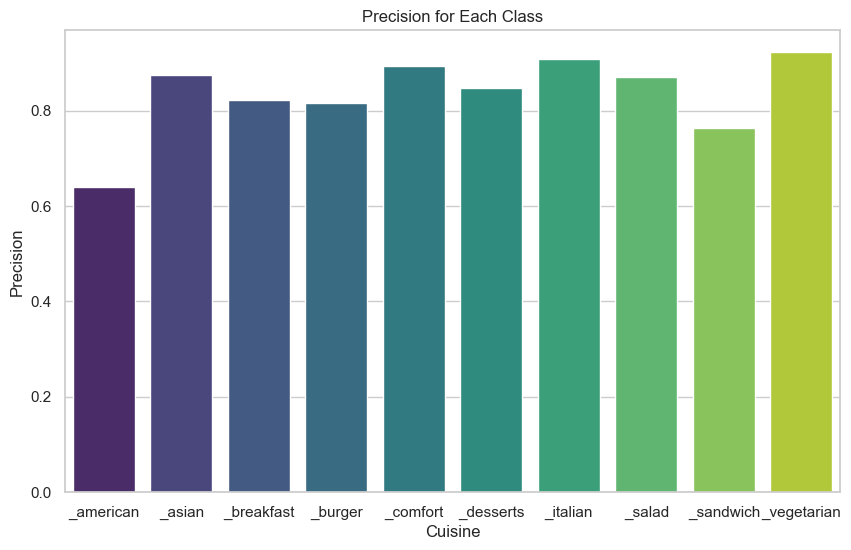

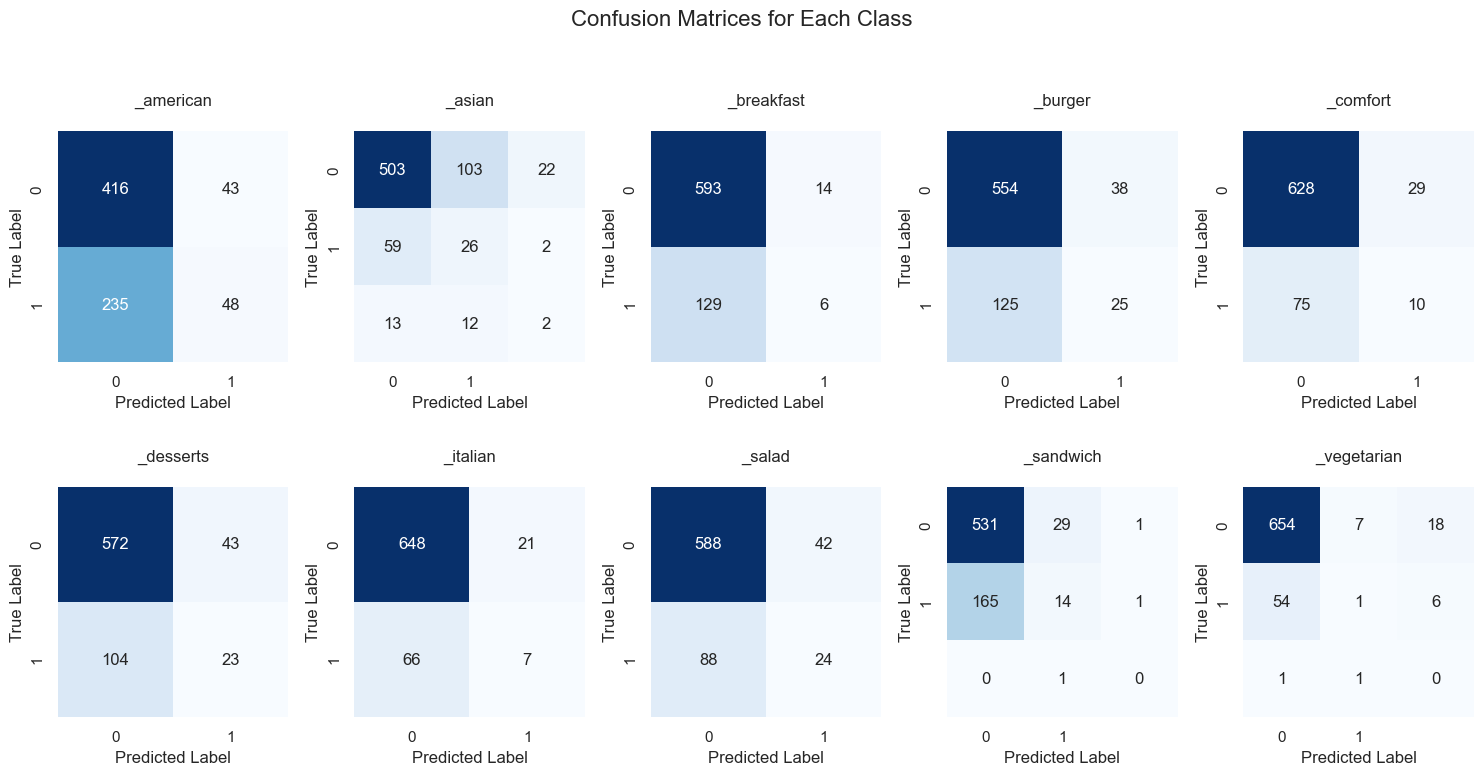

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

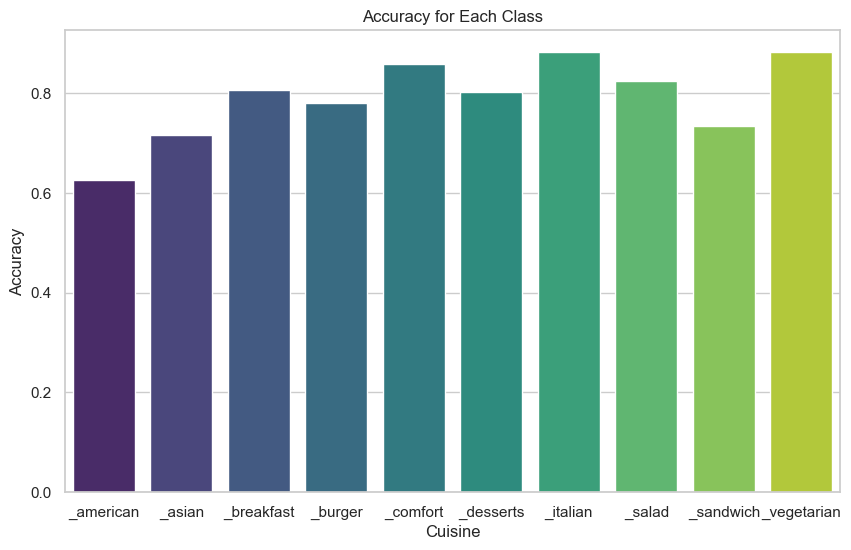

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

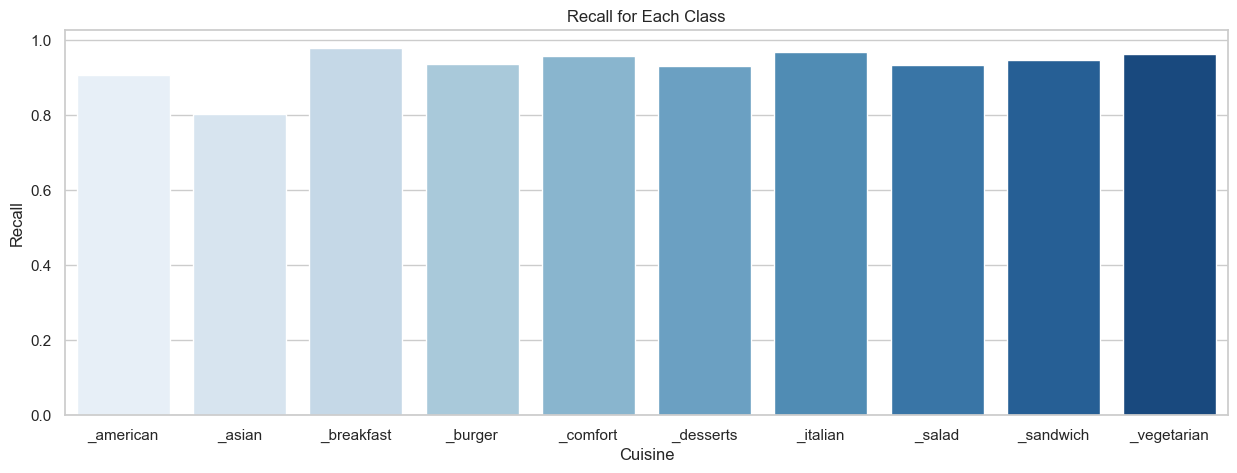

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

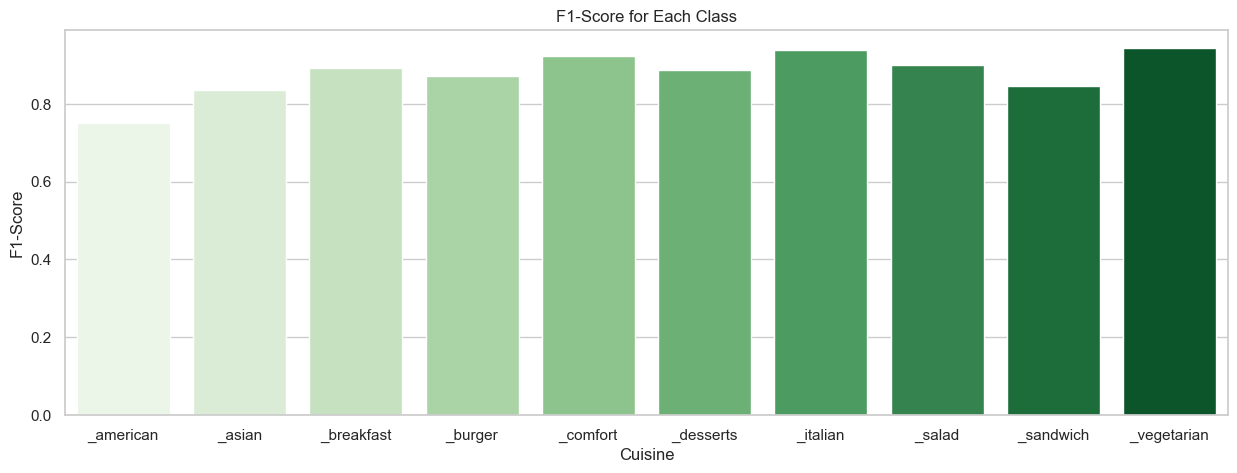

In [154]:
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = df.drop(df.columns[6:], axis=1)
y = df[df.columns[6:]]  

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train one Gaussian Naive Bayes model per cuisine type
models_per_cuisine = {}

for cuisine in y_train.columns:
    model = GaussianNB()
    model.fit(X_train_scaled, y_train[cuisine])
    models_per_cuisine[cuisine] = model

# Make predictions on the test set
y_pred = pd.DataFrame({cuisine: model.predict(X_test_scaled) for cuisine, model in models_per_cuisine.items()})

# Evaluate the model
classification_reports = {}
for cuisine in y_test.columns:
    report = classification_report(y_test[cuisine], y_pred[cuisine], output_dict=True)
    classification_reports[cuisine] = report

# classification reports
for cuisine, report in classification_reports.items():
    print(f'Classification Report for {cuisine}:')
    print(report)
    
sns.set(style="whitegrid")

# Plot for precision
precision_data = {cuisine: report['0']['precision'] for cuisine, report in classification_reports.items()}
plt.figure(figsize=(10, 6))
sns.barplot(x=list(precision_data.keys()), y=list(precision_data.values()), palette="viridis")
plt.title('Precision for Each Class')
plt.xlabel('Cuisine')
plt.ylabel('Precision')
plt.show()

confusion_matrices = {cuisine: confusion_matrix(y_test[cuisine], y_pred[cuisine]) for cuisine in y_test.columns}


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
fig.suptitle('Confusion Matrices for Each Class', fontsize=16)

for i, (cuisine, matrix) in enumerate(confusion_matrices.items()):
    ax = axes[i // 5, i % 5]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=['0', '1'], yticklabels=['0', '1'], ax=ax)
    ax.set_title(f'{cuisine}\n')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# accuracies
accuracies = {cuisine: report['accuracy'] for cuisine, report in classification_reports.items()}
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
plt.title('Accuracy for Each Class')
plt.xlabel('Cuisine')
plt.ylabel('Accuracy')
plt.show()

# Plot recall for each class
recall_data = {cuisine: report['0']['recall'] for cuisine, report in classification_reports.items()}
plt.figure(figsize=(15, 5))
sns.barplot(x=list(recall_data.keys()), y=list(recall_data.values()), palette="Blues")
plt.title('Recall for Each Class')
plt.xlabel('Cuisine')
plt.ylabel('Recall')
plt.show()

# Plot F1-score for each class
f1_score_data = {cuisine: report['0']['f1-score'] for cuisine, report in classification_reports.items()}
plt.figure(figsize=(15, 5))
sns.barplot(x=list(f1_score_data.keys()), y=list(f1_score_data.values()), palette="Greens")
plt.title('F1-Score for Each Class')
plt.xlabel('Cuisine')
plt.ylabel('F1-Score')
plt.show()

In [155]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

df1 = df
df1['cuisine'] = df.iloc[:, 6:].idxmax(axis=1).apply(lambda x: x[1:])

df1 = df1.drop(df.columns[6:-1], axis=1)

# Encode categorical feature
label_encoder = LabelEncoder()
df1['cuisine'] = label_encoder.fit_transform(df1['cuisine'])


# Split the dataset into training and testing sets
X = df1.drop(['cuisine'], axis=1)
y = df1['cuisine']

Epoch [1/1000], Loss: 2.3003
Epoch [101/1000], Loss: 2.0965
Epoch [201/1000], Loss: 2.0920
Epoch [301/1000], Loss: 2.0916
Epoch [401/1000], Loss: 2.0915
Epoch [501/1000], Loss: 2.0915
Epoch [601/1000], Loss: 2.0915
Epoch [701/1000], Loss: 2.0914
Epoch [801/1000], Loss: 2.0914
Epoch [901/1000], Loss: 2.0913


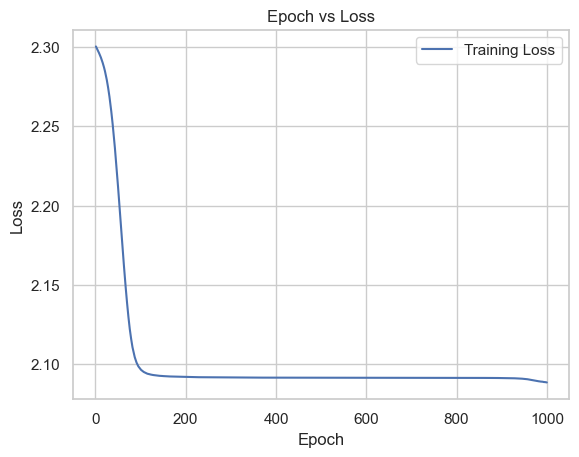

Accuracy: 0.3867924528301887
Precision: [0.38545953 0.46153846 0.         0.         0.         0.
 0.         0.         0.         0.        ]
Recall: [0.9964539  0.05263158 0.         0.         0.         0.
 0.         0.         0.         0.        ]
F1-Score: [0.55588526 0.09448819 0.         0.         0.         0.
 0.         0.         0.         0.        ]


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


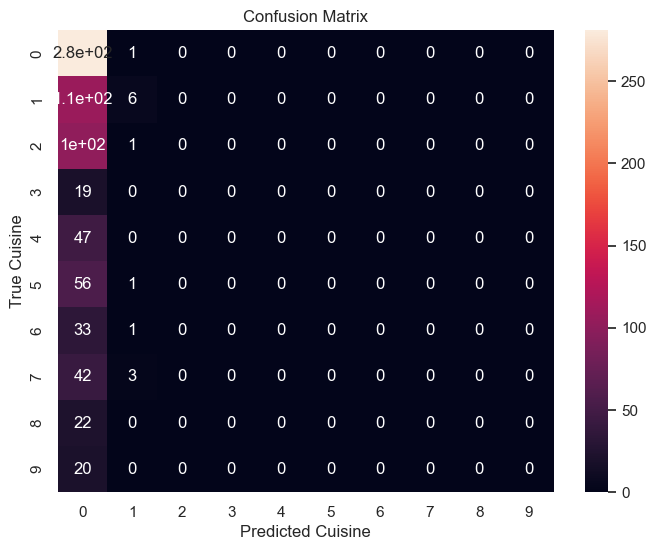

In [156]:

# Define the neural network model
class CuisineClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(CuisineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.RReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.RReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

def NNModel(X,y, output):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test.values)
    
    input_size = X_train_scaled.shape[1]
    hidden_size1 = 128
    hidden_size2 = 64
    hidden_size3 = 32
    output_size = output

    model = CuisineClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.3 * 10** -3)

    # Training the model
    num_epochs = 1000

    running_loss = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    model.eval()
    y_pred_probs = model(X_test_tensor)
    _, y_pred = torch.max(y_pred_probs, 1)

    # Convert predictions to NumPy array
    y_test_np = y_test_tensor.numpy()
    y_pred_np = y_pred.numpy()
    
    plt.plot(range(1, num_epochs + 1), running_loss, label='Training Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate accuracy
    accuracy = np.sum(y_pred_np == y_test_np) / len(y_test_np)
    print(f'Accuracy: {accuracy}')
    conf_matrix = confusion_matrix(y_test_np, y_pred_np)
    precision,recall,fscore,support = precision_recall_fscore_support(y_test_np,y_pred_np)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", fscore)
    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True)
    plt.xlabel('Predicted Cuisine')
    plt.ylabel('True Cuisine')
    plt.title('Confusion Matrix')
    plt.show()
    return model

nnModel = NNModel(X, y, len(label_encoder.classes_))

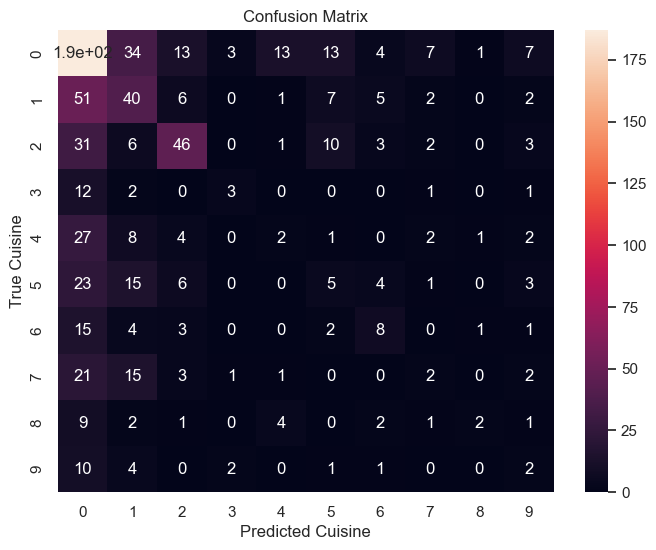

Precision: [0.48445596 0.30769231 0.56097561 0.33333333 0.09090909 0.12820513
 0.2962963  0.11111111 0.4        0.08333333]
Recall: [0.66312057 0.35087719 0.45098039 0.15789474 0.04255319 0.0877193
 0.23529412 0.04444444 0.09090909 0.1       ]
F1-Score: [0.55988024 0.32786885 0.5        0.21428571 0.05797101 0.10416667
 0.26229508 0.06349206 0.14814815 0.09090909]
Random Forest Accuracy: 0.4002695417789757


In [157]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
def RandomForest(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test_scaled)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True)
    plt.xlabel('Predicted Cuisine')
    plt.ylabel('True Cuisine')
    plt.title('Confusion Matrix')
    plt.show()
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", fscore)
    print(f'Random Forest Accuracy: {accuracy}')
    return rf_model

rf_model = RandomForest(X, y)

[0.24797843665768193, 0.3261455525606469, 0.3261455525606469, 0.3194070080862534, 0.33557951482479786, 0.3328840970350404, 0.3423180592991914, 0.3584905660377358, 0.35714285714285715, 0.35444743935309975, 0.35444743935309975, 0.3638814016172507, 0.3584905660377358, 0.36253369272237196, 0.36253369272237196, 0.3746630727762803, 0.36253369272237196, 0.37331536388140163, 0.37331536388140163, 0.37735849056603776, 0.37735849056603776, 0.37870619946091644, 0.37735849056603776, 0.37735849056603776, 0.3692722371967655, 0.37870619946091644, 0.37331536388140163, 0.37870619946091644, 0.37735849056603776, 0.37870619946091644, 0.38005390835579517, 0.38274932614555257, 0.37870619946091644, 0.37870619946091644, 0.38005390835579517, 0.37735849056603776, 0.38005390835579517, 0.38005390835579517, 0.38140161725067384, 0.38409703504043125, 0.38274932614555257, 0.38409703504043125, 0.38409703504043125, 0.38274932614555257, 0.38140161725067384, 0.3867924528301887, 0.38409703504043125, 0.38544474393531, 0.384

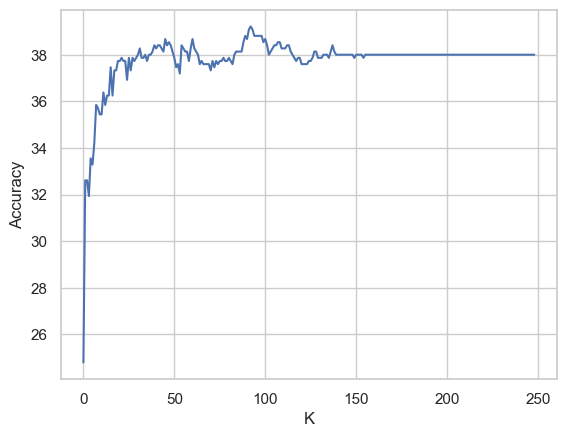

Best k=93 Accuracy: 39.22%


In [158]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X_knn = df[['ratingValue', 'priceRange', 'reviewCount', 'latitude', 'longitude']]
y_knn = df['cuisine']

label_encoder = LabelEncoder()
y_knn = label_encoder.fit_transform(y_knn)

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.20, random_state=42)

accuracy_list = []
best_k = 1
for k in range(1, 250):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)

    knn_classifier.fit(X_train_knn, y_train_knn)

    y_pred_knn = knn_classifier.predict(X_test_knn)

    accuracy_list.append(accuracy_score(y_test_knn, y_pred_knn))
    
print(accuracy_list)
plt.plot(range(len(accuracy_list)), [x* 100 for x in accuracy_list])
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()
print(f'Best k={np.argmax(accuracy_list)+1} Accuracy: {np.max(accuracy_list) * 100:.2f}%')

In [159]:
from sklearn.model_selection import train_test_split

X_svm = top_10_df[['ratingValue','reviewCount','priceRange']]
y_svm = top_10_df['cuisine']
y_svm = y_svm.astype('int64')

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [160]:
svm_classifier = SVC( random_state=42)

In [161]:
svm_classifier = svm_classifier.fit(X_train_svm, y_train_svm)

y_pred_svm = svm_classifier.predict(X_test_svm)
accuracy = accuracy_score(y_test_svm, y_pred_svm)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 38.14%


Text(0.5, 1.0, 'Confusion Matrix for SVM Classifier')

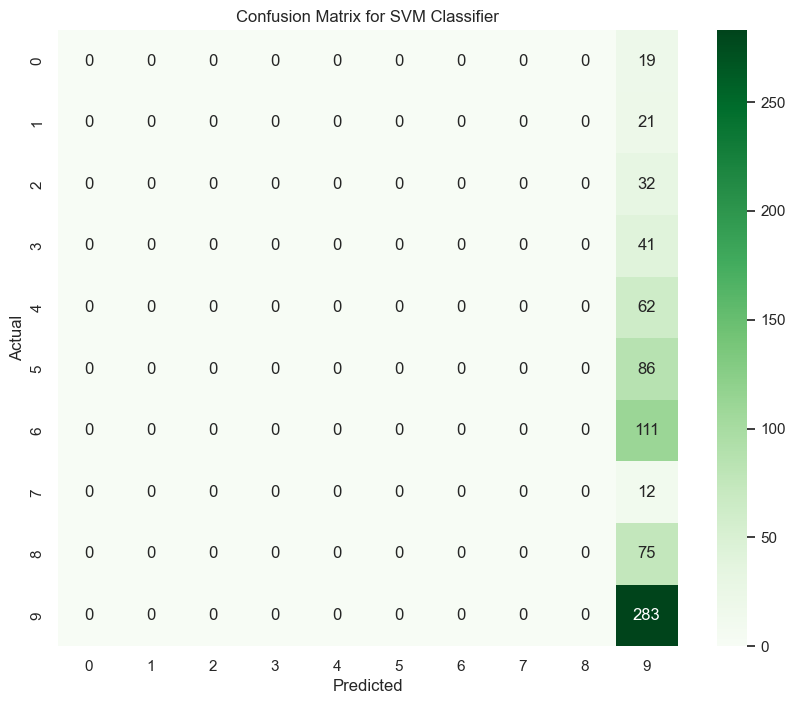

In [162]:
svm_conf_matrix = confusion_matrix(y_test_svm, y_pred_svm)

import seaborn as sns 

plt.figure(figsize=(10, 8))
sns.heatmap(svm_conf_matrix, fmt='d',annot=True, cmap='Greens')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM Classifier')